###**COMPUTER VISION PROJECT**

In [1]:
!pip install torch

In [ ]:
! pip install scikit-image --quiet

In [3]:
! pip install opencv-python --quiet

In [2]:
! pip install Pillow

In [6]:
import numpy as np
import random
import torch
import scipy
import skimage
import PIL
import os
import torchvision
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import datasets, transforms
from torchvision.models import resnet50
from PIL import Image
import matplotlib.pyplot as plt

In [7]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


torch.Size([3, 1000, 2000])
torch.Size([3, 1000, 2000])


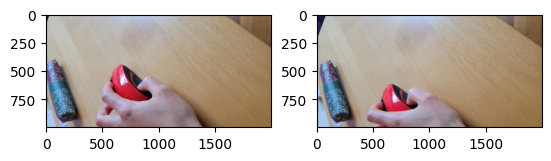

In [12]:
# images to test the optical flow algorithm

transform = transforms.Compose([transforms.PILToTensor(), transforms.Resize([1000,2000])]) ######## image shape

img1 = Image.open('/content/drive/MyDrive/VPPROJECT/images_optical_flow/20230528_184032.jpg')   #### insert your path
img1 = transform(img1)
print(img1.shape)

img2 = Image.open('/content/drive/MyDrive/VPPROJECT/images_optical_flow/20230528_184035.jpg')   #### insert your path
img2 = transform(img2)
print(img2.shape)

plt.subplot(1, 2, 1)
plt.imshow(img1.permute(1, 2, 0))
plt.subplot(1, 2, 2)
plt.imshow(img2.permute(1, 2, 0))


###Lucas-Kanade Algorithm

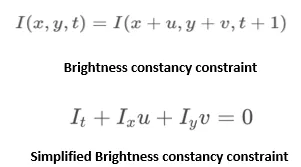

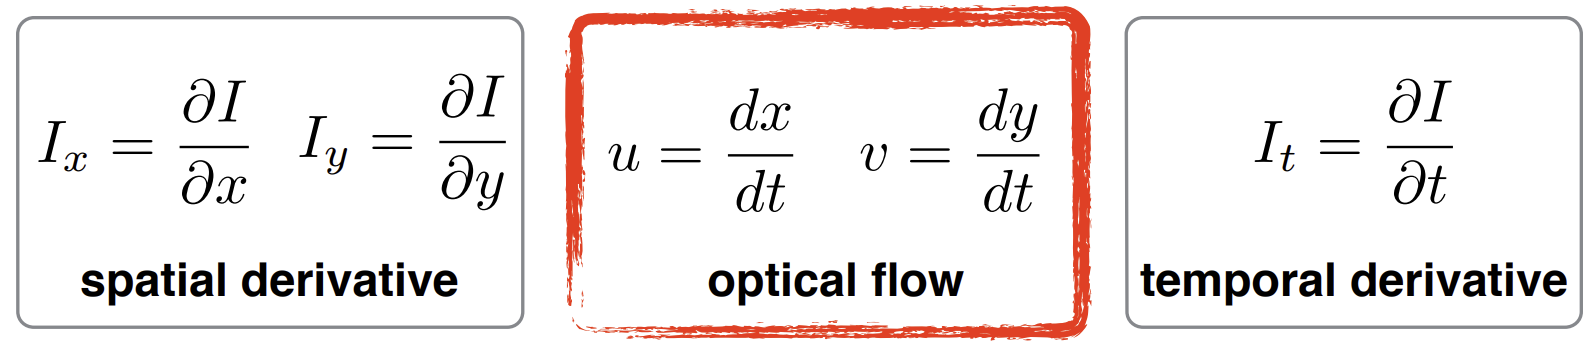

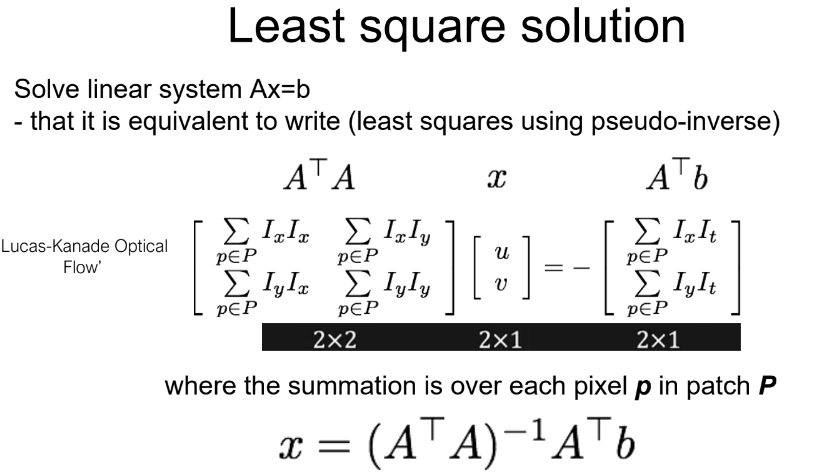

In [13]:
def divide_into_patches(img):

    # adapt patch number to image shape

    img = img.numpy()
    print("Image shape: ", img.shape)
    dim_patch = 8
    print("Patch shape: ", dim_patch)
    num_patches = (img.shape[1] / dim_patch) * (img.shape[2] / dim_patch)
    print("Number of patches: ", int(num_patches))
    patches = skimage.util.view_as_blocks(img, (3, dim_patch, dim_patch))
    patches = torch.from_numpy(patches)
    print("Patched image tensor shape: ", patches.shape)

    return patches

Image shape:  (3, 1000, 2000)
Patch shape:  8
Number of patches:  31250
Patched image tensor shape:  torch.Size([1, 125, 250, 3, 8, 8])


Image shape:  (3, 1000, 2000)
Patch shape:  8
Number of patches:  31250
Patched image tensor shape:  torch.Size([1, 125, 250, 3, 8, 8])
Image shape:  (3, 1000, 2000)
Patch shape:  8
Number of patches:  31250
Patched image tensor shape:  torch.Size([1, 125, 250, 3, 8, 8])
Optical flow is given by 125x250 vectors 2x1: torch.Size([1, 125, 250, 2, 1])
Magnitude opt_flow matrix:  torch.Size([1, 125, 250, 1])
Orientation opt_flow matrix:  torch.Size([1, 125, 250, 1])


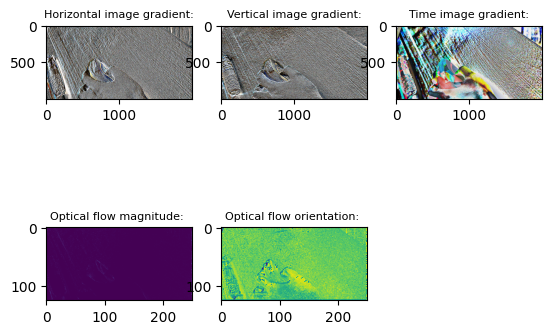

In [14]:
def optical_flow_lucas_kanade(img_a, img_b):  ################# RISCRITTO TUTTO A MANO A PARTIRE DALLE SLIDE DELLA PROF waaaa <3

    # Lucas-Kanade hypothesis: constant flow in image patches

    # img gradient computation applying the Sobel filter:
    sobel_filter_horizontal = torch.Tensor([[[1, 0, -1], [2, 0, -2], [1, 0, -1]]])
    sobel_filter_vertical = torch.Tensor([[[1, 2, 1], [0, 0, 0], [-1, -2, -1]]])
    Sx = sobel_filter_horizontal.repeat(3,1,1) # 3x3x3 kernel for 2D convolution
    Sy = sobel_filter_vertical.repeat(3,1,1)

    # x image gradient with Sobel filter
    Ix = scipy.signal.convolve(img_a, Sx, mode = 'same')
    Ix = torch.from_numpy(Ix)
    plt.subplot(2,3,1)
    plt.title("Horizontal image gradient:", fontsize=8)
    plt.imshow(Ix.permute(1, 2, 0))

    Ix_patched = divide_into_patches(Ix)

    # y image gradient with Sobel filter
    Iy = scipy.signal.convolve(img_a, Sy, mode = 'same')
    Iy= torch.from_numpy(Iy)
    plt.subplot(2,3,2)
    plt.title("Vertical image gradient:", fontsize=8)
    plt.imshow(Iy.permute(1, 2, 0))

    Iy_patched = divide_into_patches(Iy)

    # temporal gradient (pixel-by-pixel difference between consecutive frames)
    It = np.subtract(img_a, img_b)
    plt.subplot(2,3,3)
    plt.title("Time image gradient:", fontsize=8)
    plt.imshow(It.permute(1, 2, 0))

    It_patched = divide_into_patches(It).type(torch.FloatTensor)

    dim_patch = 8
    num_patches = (img_a.shape[1] / dim_patch) * (img_a.shape[2] / dim_patch)
    optical_flow_patched = torch.zeros((1,125,250,2,1))
    magnitude_opt_flow_patched = torch.zeros((1,125,250,1))
    orientation_opt_flow_patched = torch.zeros((1,125,250,1))
    for n in range(250):
        for m in range(125):
            Ix_patch = Ix_patched[0][m][n]
            Iy_patch = Iy_patched[0][m][n]
            It_patch = It_patched[0][m][n]
            # build matrices in order to solve the system above:   [u,v] = (A_T * A)^-1 * (A_T * b)
            # A_T * A = covariance_matrix
            # A_T * b = vector
            c_11 = torch.sum(torch.square(Ix_patch))
            c_12 = torch.sum(torch.mul(Ix_patch, Iy_patch))
            c_21 = c_12
            c_22 = torch.sum(torch.square(Iy_patch))
            covariance_mat = torch.tensor([[c_11, c_12], [c_21, c_22]])
            v_1 = torch.sum(torch.mul(Ix_patch, It_patch))
            v_2 = torch.sum(torch.mul(Ix_patch, It_patch))
            vector = torch.tensor([[v_1], [v_2]])
            estimated_opt_flow_patch = torch.matmul(torch.inverse(covariance_mat), vector)
            optical_flow_patched[0][m][n] = estimated_opt_flow_patch
            magnitude_opt_flow_patched[0][m][n] = torch.norm(estimated_opt_flow_patch)
            orientation_opt_flow_patched[0][m][n] = torch.atan(estimated_opt_flow_patch[1]/estimated_opt_flow_patch[0])
    return optical_flow_patched, magnitude_opt_flow_patched, orientation_opt_flow_patched

opt_flow = optical_flow_lucas_kanade(img1,img2)

print("Optical flow is given by 125x250 vectors 2x1:", opt_flow[0].shape)

print("Magnitude opt_flow matrix: ", opt_flow[1].shape)
plt.subplot(2,3,4)
plt.title("Optical flow magnitude: ", fontsize=8)
plt.imshow(opt_flow[1].squeeze())

print("Orientation opt_flow matrix: ", opt_flow[2].shape)
plt.subplot(2,3,5)
plt.title("Optical flow orientation: ", fontsize=8)
plt.imshow(opt_flow[2].squeeze())